# Fraud Detection using Ensemble Methods

## Importing Libraries

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

## Data Collection

In [4]:
df = pd.read_csv('C:/Users/kumar/OneDrive/Desktop/Machine Learning Project/datasets/fraud detection dataset.csv')
df.shape

(5000, 21)

## Data Preprocessing 

In [5]:
print("Dataset shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)

Dataset shape: (5000, 21)

Missing values:
 click_id                 0
timestamp                0
user_id                  0
ip_address               0
device_type              0
browser                  0
operating_system         0
referrer_url             0
page_url                 0
click_duration           0
scroll_depth             0
mouse_movement           0
keystrokes_detected      0
ad_position              0
click_frequency          0
time_since_last_click    0
device_ip_reputation     0
VPN_usage                0
proxy_usage              0
bot_likelihood_score     0
is_fraudulent            0
dtype: int64

Data types:
 click_id                  object
timestamp                 object
user_id                   object
ip_address                object
device_type               object
browser                   object
operating_system          object
referrer_url              object
page_url                  object
click_duration           float64
scroll_depth               int64

In [7]:
df_clean = df.dropna()
print(f"Rows after removing NaN: {df_clean.shape[0]}")
print(f"Class distribution:\n{df_clean.iloc[:, -1].value_counts()}\n")

X = df_clean.drop(df_clean.columns[-1], axis=1)
y = df_clean.iloc[:, -1]

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X = X[numeric_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

Rows after removing NaN: 5000
Class distribution:
is_fraudulent
0    3759
1    1241
Name: count, dtype: int64

Train set: (4000, 9)
Test set: (1000, 9)


## Training and Evaluation

In [8]:
lr = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
svc = SVC(kernel='linear', probability=True, random_state=42)

voting_clf = VotingClassifier([('lr', lr), ('rf', rf), ('gb', gb), ('svc', svc)], voting='soft')

voting_clf.fit(X_train_scaled, y_train)
y_pred = voting_clf.predict(X_test_scaled)

print(f"Ensemble Model Training completed")

Ensemble Model Training completed


In [9]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, voting_clf.predict_proba(X_test_scaled)[:, 1])

print("Ensemble Model Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {roc_auc:.4f}")

Ensemble Model Metrics:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
AUC-ROC:   1.0000


In [10]:
models = [lr, rf, gb, svc]
model_names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'SVC']
model_acc = []

for model, name in zip(models, model_names):
    model.fit(X_train_scaled, y_train)
    y_pred_model = model.predict(X_test_scaled)
    acc_model = accuracy_score(y_test, y_pred_model)
    model_acc.append(acc_model)
    print(f"{name:25} - Accuracy: {acc_model:.4f}")

print(f"{'Voting Ensemble':25} - Accuracy: {accuracy:.4f}")

Logistic Regression       - Accuracy: 0.9960
Random Forest             - Accuracy: 1.0000
Gradient Boosting         - Accuracy: 1.0000
SVC                       - Accuracy: 0.9950
Voting Ensemble           - Accuracy: 1.0000


## Plots and Analysis

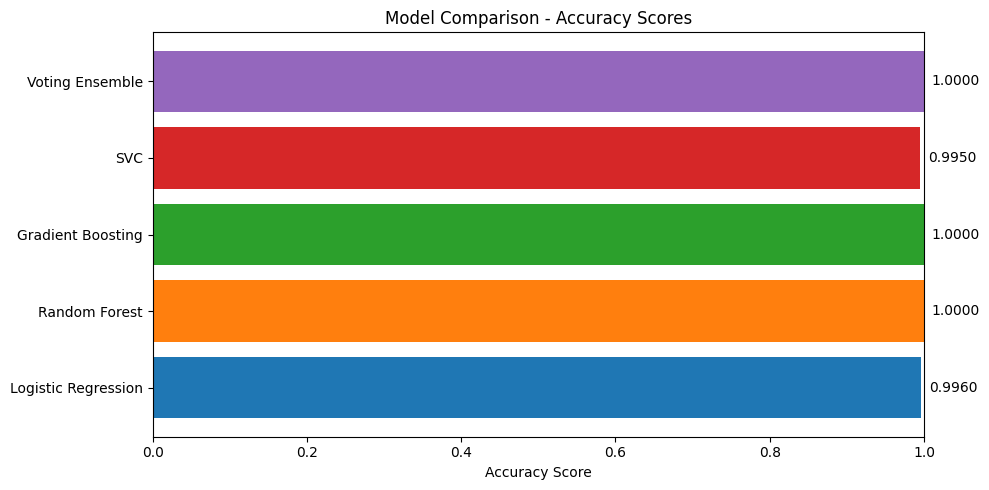

In [11]:
plt.figure(figsize=(10, 5))
models_list = model_names + ['Voting Ensemble']
acc_scores = model_acc + [accuracy]
plt.barh(models_list, acc_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.xlabel('Accuracy Score')
plt.title('Model Comparison - Accuracy Scores')
plt.xlim(0, 1)
for i, v in enumerate(acc_scores):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center')
plt.tight_layout()
plt.show()

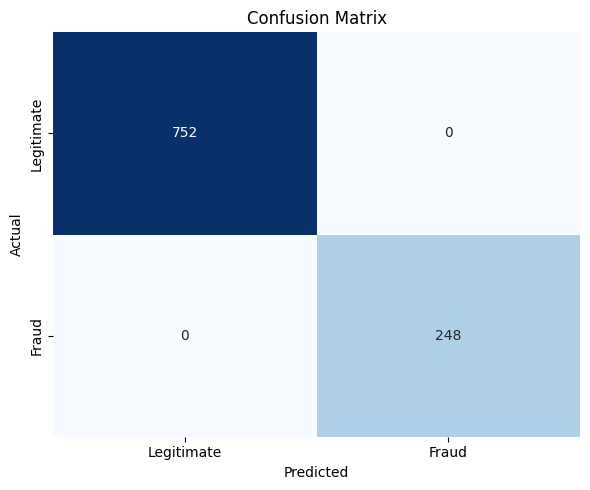


Confusion Matrix Analysis:
TN: 752, FP: 0, FN: 0, TP: 248
Specificity: 1.0000
Sensitivity: 1.0000


In [12]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Legitimate', 'Fraud'], yticklabels=['Legitimate', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print(f"\nConfusion Matrix Analysis:")
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
print(f"Specificity: {specificity:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")

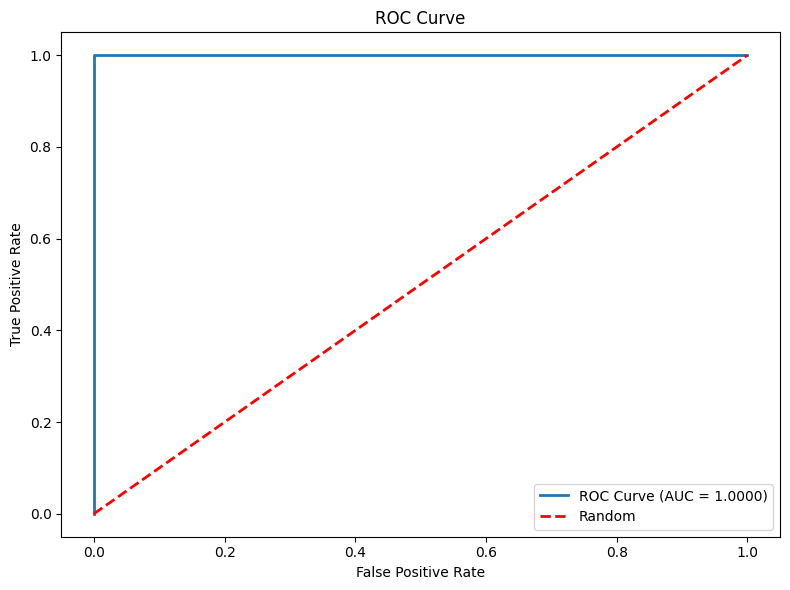

In [13]:
y_pred_proba = voting_clf.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

Thanks!